In [54]:
using Pkg

In [55]:
Pkg.activate(dirname(pwd()))

  Activating project at `~/Documents/GitHub/ComputationalHeatTransfer.jl`


In [56]:
using ComputationalHeatTransfer
using LaTeXStrings
using JLD2
using Plots
gr()  


Plots.GRBackend()

## Control Console

In [282]:
# fluid_type = "butane"
# fluid_type = "R134a"
# Tᵥ = 291.2

ΔTthres = 2.0
δfilm = 3e-5
ad_fac = 1.0
plate_d = 1.5e-3;
# hc1 = 3000.0
# hc1 = 0.0
# hc2 = 3000.0
Eratio = 0.5

0.5

In [283]:
# fluid_type = "butane"
# Tᵥ = 291.2

# ΔTthres = 0.1
# δfilm = 1e-5
# plate_d = 2e-3;
# # hc1 = 3000.0
# hc1 = 0.0
# hc2 = 3000.0
# Eratio = 0.3

# Properies

### Solid Physical parameters

In [284]:
ρₛ = 2730; # density
cₛ  = 8.93e02; # specific heat
kₛ  = 1.93e02; # heat conductivity
params = HeatConductionParameters(ρₛ ,cₛ ,kₛ ,thickness=plate_d)

HeatConductionParameters(2730.0, 893.0, 193.0, 7.916682048820907e-5, 0.0015)

### Fluid Physical parameters

In [285]:
fluid_type = "Butane"
Tref = 295.0
p_fluid = SaturationFluidProperty(fluid_type,Tref);

In [286]:
# using UnPack
# @unpack Cpₗ,ρₗ,μₗ,hₗ,kₗ,Prₗ,Cpᵥ,ρᵥ,μᵥ,hᵥ,kᵥ,Prᵥ,σ,P,R,M,Rkg,αₗ,νₗ,νᵥ,hₗᵥ = p_fluid;

# Plate Conduction

### Geometry parameters

In [287]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

In [288]:
xlim = (-Lx/2,Lx/2) # plate x limits
ylim = (-Ly/2,Ly/2) # plate y limits
Δx,Δt_max = setstepsizes(params.α,gridPe=8.0,fourier=0.3)

(0.0006333345639056725, 0.001520002953373614)

## Set up the OHP

In [289]:
OHPtype = "ASETS-II OHP 2 LARGE HEATER"

"ASETS-II OHP 2 LARGE HEATER"

In [290]:
power = 40 #watts
hc = 3000.0
Tc = Tref;

In [291]:
eparams,cparams = OHPConfiguration(OHPtype,power,Tc,hc,Δx);

In [292]:
x, y, xf, yf = construct_ohp_curve("ASETS",Δx)
ohp = BasicBody(x,y)
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)

LineSourceParams{BasicBody{4877, RigidBodyTools.ClosedBody}}(Basic pointwise-specified body with 4877 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
)

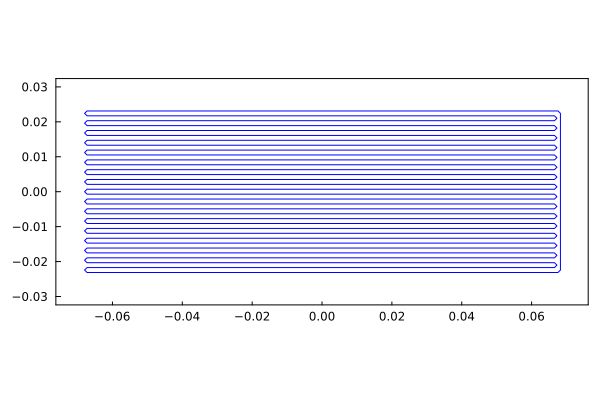

In [293]:
plot(ohpgeom.body,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)

### create HeatConduction system

In [294]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt_max,qline=ohpgeom,qflux=eparams,qmodel=cparams)

Unbounded Heat conduction system on a grid of size 250 x 108 and 0 static immersed points


# OHP inner part

### Tube geometries

In [295]:
tube_d = 1e-3; # tube diameter
peri = 4*tube_d # Tube perimeter
Ac = tube_d*tube_d # tube cross-sectional area
L2D = 133.83*1e-3 # the actual length of the bended pipe in the real world
L = (sys.qline[1].arccoord[1] + sys.qline[1].arccoord[end])  # total length of the pipe when streched to a 1D pipe (an approximate here)
angle = 0*pi/2 # inclination angle 
closedornot = true

N=numpts(ohp);

In [296]:
tube = Tube(tube_d,peri,Ac,L,L2D,angle,gravity,closedornot,N);

In [297]:
typeof(tube)

Tube

### Liquid

In [298]:
Nu = 3.60
# Nu = 1.0
Hₗ = p_fluid.kₗ/tube_d * Nu # Nusselt number 4.36

381.68885816494867

In [299]:
X0,realratio = randomXp(tube)
# X0 = [(L/2,L/2+L2D)]

dXdt0_l = zeros(length(X0))
dXdt0_r = zeros(length(X0))
dXdt0 = map(tuple,dXdt0_l,dXdt0_r);

In [300]:
realratio

0.4393634023987944

In [301]:
# construct liquids
N=numpts(ohp)
Xarrays,θarrays = constructXarrays(X0,N,Tref,L);

In [302]:
liquids=Liquid(Hₗ,p_fluid.ρₗ,p_fluid.Cpₗ,p_fluid.αₗ,p_fluid.μₗ,p_fluid.σ,X0,dXdt0,Xarrays,θarrays);

### Vapor

In [303]:
Hᵥ = p_fluid.kᵥ/tube_d * Nu # Nusselt number 4.36

58.581618687531844

In [304]:
P = 0*zeros(length(X0)) .+ TtoP(Tref);
# δ = 0*zeros(length(X0)) .+ 1.0e-5;
δfilm_deposit = δfilm;
δstart = 0*zeros(length(X0)) .+ δfilm ;
δend = 0*zeros(length(X0)) .+ δfilm ;

Lvaporplug = XptoLvaporplug(X0,L,tube.closedornot)
Lfilm_start = 0.01 .* Lvaporplug
Lfilm_end = 0.01 .* Lvaporplug
# Eratio = 0.75
# δratio = 0*zeros(length(X0)) .+ 0.99;
# δ = 0*zeros(length(X0)) .+ 2.78E-02;
δmin = 2e-6
vapors=Vapor(Hᵥ,p_fluid.kₗ,δmin,Eratio,P,δfilm_deposit,δstart,δend,Lfilm_start,Lfilm_end);

### Wall

### nucleate boiling sites

In [305]:
# ΔTthres = 1.0; # superheat threshold

In [306]:
    nucleatenum = 256
#     Xstations = sort(rand(nucleatenum).*L);
 Xstations = sort(rand(nucleatenum) .* L);
#     Xstations = LinRange(0.0,L-L/nucleatenum,nucleatenum)
#     boilingΔt = 0.05

In [307]:
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,Tref);
θwallarray .= Tref

wall = Wall(ΔTthres,Xstations,Xwallarray,θwallarray);

In [308]:
sys0_nomapping = PHPSystem_nomapping(tube,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [309]:
L

4.650670248837519

In [310]:
sys0 = PHPSystem(tube,liquids,vapors,wall,mapping);

### construct state vector U

In [311]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = PtoD(P) .* Lvaporplug .* Ac
# M = P.^(1/γ).* Lvaporplug



u=[XMδLtovec(X0,dXdt0,M,δstart,δend,Lfilm_start,Lfilm_end); liquidθtovec(sys0.liquid.θarrays)];
# u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [312]:
function immersedboundary_condition(u,t,integrator)
    true
end

immersedboundary_condition (generic function with 1 method)

In [313]:
function immersedboundary_affect!(integrator)
    integrator.p.wall.θarray = deepcopy(temperature_linesource(Main.integrator_plate))
end

immersedboundary_affect! (generic function with 1 method)

In [314]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
cb_vapormerging =  DiscreteCallback(merging_condition,merging_affect!)
cb_liquidmerging = DiscreteCallback(vaporMergingCondition,vaporMergingAffect!)
cb_fixdx =  DiscreteCallback(fixdx_condition,fixdx_affect!)
# cb_immersedboundary = DiscreteCallback(immersedboundary_condition,immersedboundary_affect!)

cbst = CallbackSet(cb_fixdx,cb_boiling,cb_vapormerging,cb_liquidmerging);
# cbst = CallbackSet(cb_vapormerging,cb_liquidmerging);

# load old data

In [315]:
# integrator_plate = load("plate_OHP_dimensional50D1.0TH1_H2250_platethickness1.5.jld2", "integrator_plate")
# sys = integrator_plate.p

In [316]:
# integrator_tube = load("tube_OHP_dimensional50D1.0TH1_H2250_platethickness1.5.jld2", "integrator_tube")

# # sysfinal = []
# # for i = 1:length(tube_hist)
# #     push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
# # end

In [317]:
# tube_hist = load("tube_vibration.jld2", "tube_hist")

# combine inner tube and plate together

In [318]:
tspan = (0.0, 10.0);
num_data = 100
dt_record = tspan[2] /num_data;
# dt_record_tube = 0.1;

tstep = 1e-3

N_iter = 1
# tstep_plate = tstep/N_iter
# dt_record = tstep

1

In [319]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)
temperature(integrator_plate) .= Tref;

In [320]:
p = sys0
u=[XMδLtovec(X0,dXdt0,M,δstart,δend,Lfilm_start,Lfilm_end); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_on=false, dt=tstep, callback=cbst);
currentsys = getcurrentsys(integrator_tube.u,integrator_tube.p);

## Resume

In [321]:
# integrator_plate = integrator_plate_temp;

In [322]:
# integrator_tube = tube_hist[end];

## Start

In [323]:
boil_hist=[]
plate_T_hist = []
tube_hist_u  = []
tube_hist_t = []
tube_hist_θwall = []

Any[]

In [324]:
using Distributed
using ProgressMeter

In [325]:
integrator_plate.t

0.0

In [326]:
#  step!(integrator_tube,tstep,true);

#        currentsys.wall.θarray = temperature_linesource(integrator_plate)
#        currentsys = getcurrentsys(integrator_tube.u,currentsys)

#        qtmp = sys_to_heatflux(currentsys)
#        set_linesource_strength!(sys,qtmp)



In [341]:
prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t,integrator_plate.t+tspan[2]-tspan[1]), currentsys)
integrator_tube = init(prob, RK4(), callback=cbst, dt=tstep,save_on=false);

@showprogress for t in tspan[1]:tstep:tspan[2]
# @time for t in tspan[1]:tstep:tspan[1]
     step!(integrator_tube,tstep,true);

        currentsys = deepcopy(getcurrentsys(integrator_tube.u,integrator_tube.p))
        currentsys.wall.θarray = deepcopy(temperature_linesource(integrator_plate))
        integrator_tube.p = deepcopy(currentsys)
        qtmp = deepcopy(sys_to_heatflux(currentsys))
       set_linesource_strength!(sys,qtmp)


     ADI_timemarching!(temperature(integrator_plate),sys,tstep)

    integrator_plate.t += tstep
    
    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_T_hist,deepcopy(temperature(integrator_plate))); 
        push!(tube_hist_θwall,deepcopy(integrator_tube.p.wall.θarray))
        push!(tube_hist_u,deepcopy(integrator_tube.u));
        push!(tube_hist_t,deepcopy(integrator_tube.t));
        integrator_plate_temp = deepcopy(integrator_plate)
#         println(sys.qline[1].q[1:5])
    end
    
end
# integrator_plate.t

Progress:   1%|▍                                        |  ETA: 0:06:40

reconstruct dx! in6 at 10.768324194052681


Progress:   9%|███▊                                     |  ETA: 0:04:58

reconstruct dx! in9 at 11.58945158363781


Progress:  11%|████▌                                    |  ETA: 0:04:59

reconstruct dx! in7 at 11.772276296923277


Progress:  11%|████▋                                    |  ETA: 0:04:58

reconstruct dx! in7 at 11.79155600600324


Progress:  11%|████▋                                    |  ETA: 0:05:00

vapor merged!


Progress:  23%|█████████▎                               |  ETA: 0:04:50

reconstruct dx! in6 at 12.932601124674614


Progress:  34%|██████████████                           |  ETA: 0:04:17

reconstruct dx! in4 at 14.071707185889924


Progress:  50%|████████████████████▍                    |  ETA: 0:03:11

reconstruct dx! in14 at 15.645786039525241


Progress:  50%|████████████████████▌                    |  ETA: 0:03:11

reconstruct dx! in6 at 15.660309799228571


Progress:  54%|██████████████████████▎                  |  ETA: 0:03:05

reconstruct dx! in9 at 16.08238479620078


Progress:  55%|██████████████████████▍                  |  ETA: 0:03:04

LoadError: InterruptException:

In [342]:
boil_hist

80-element Vector{Any}:
 [232.0, 6.600000000000539]
 [199.0, 6.700000000000572]
 [220.0, 6.700000000000572]
 [199.0, 6.800000000000606]
 [86.0, 6.900000000000639]
 [12.0, 7.000000000000672]
 [43.0, 7.200000000000739]
 [39.0, 7.3000000000007725]
 [74.0, 7.3000000000007725]
 [220.0, 7.700000000000906]
 [232.0, 7.700000000000906]
 [230.0, 8.10000000000095]
 [240.0, 8.10000000000095]
 ⋮
 [188.0, 15.699998523285501]
 [52.0, 15.79999703750328]
 [38.0, 15.899999999996627]
 [52.0, 15.899999999996627]
 [240.0, 15.899999999996627]
 [12.0, 15.999999999996572]
 [38.0, 15.999999999996572]
 [58.0, 15.999999999996572]
 [57.0, 16.099999999996694]
 [65.0, 16.099999999996694]
 [72.0, 16.099999999996694]
 [92.0, 16.099999999996694]

In [343]:
sysfinal = []
for i = 1:length(tube_hist_u)
    sysfinaltemp = deepcopy(getcurrentsys(tube_hist_u[i],integrator_tube.p))
    sysfinaltemp.wall.θarray = tube_hist_θwall[i]
    push!(sysfinal, sysfinaltemp)
end

In [ ]:
scatter()
for i=1:length(tube_hist)
    Lvaporplug = XptoLvaporplug(sysfinal[i].liquid.Xp,sysfinal[end-1].tube.L,sysfinal[end].tube.closedornot);
    plot!(i,Lvaporplug)
end

In [ ]:
Δθthreshold = 0.1
Δθ_array = getsuperheat.(sysfinal[end].wall.Xstations,[sysfinal[end]])
    superheat_flag = Δθ_array .> Δθthreshold
flag = zeros(length(Xstations))
    for i = 1:length(Xstations)
    flag[i] = ifamong(sysfinal[end].wall.Xstations[i], sysfinal[end].liquid.Xp, sysfinal[end].tube.L) && suitable_for_boiling(sysfinal[end],i) && superheat_flag[i]
end
plot(flag)

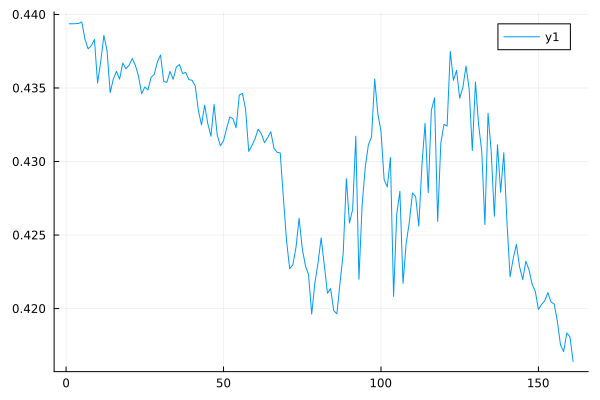

In [344]:
ss = []
for i = 1:length(sysfinal)
    push!(ss,(sum(XptoLliquidslug(sysfinal[i].liquid.Xp,L))./L))
end
plot(ss)

# plot the OHP

## Green: vapor with film-------Yellow: vapor without film-------Blue: liquid

┌ Info: Saved animation to 
│   fn = /Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/tmp.gif
└ @ Plots /Users/yuxuanli/.julia/packages/Plots/4UTBj/src/animation.jl:154


Plots.AnimatedGif("/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/tmp.gif")
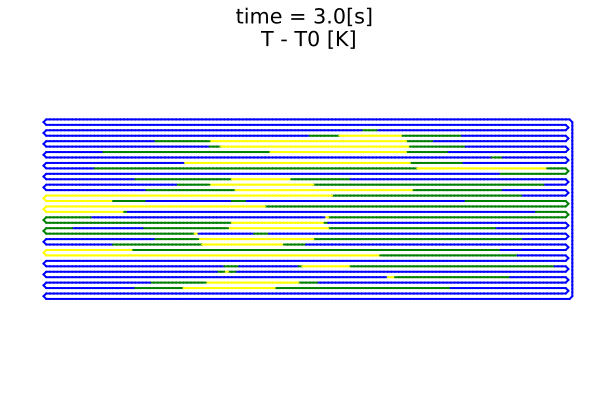

In [107]:
@gif for i=length(sysfinal):length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    Htmp_marker = round.(div.(Htmp,Hₗ-1e-10))
    plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :green]),line_z=Htmp_marker,xlabel="x ",ylabel="y ",title=string("time = ", round(tube_hist_t[i], digits=2), "[s] \n",  "T - T0 [K]"),border=:none,axis=nothing)
end

┌ Info: Saved animation to 
│   fn = /Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/tmp.gif
└ @ Plots /Users/yuxuanli/.julia/packages/Plots/4UTBj/src/animation.jl:154


Plots.AnimatedGif("/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/tmp.gif")
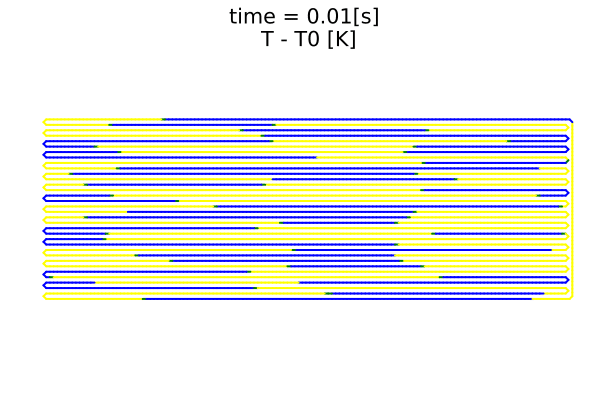

In [230]:
@gif for i=1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    Htmp_marker = round.(div.(Htmp,Hₗ-1e-10))
    plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :green]),line_z=Htmp_marker,xlabel="x ",ylabel="y ",title=string("time = ", round(tube_hist_t[i], digits=2), "[s] \n",  "T - T0 [K]"),border=:none,axis=nothing)
end

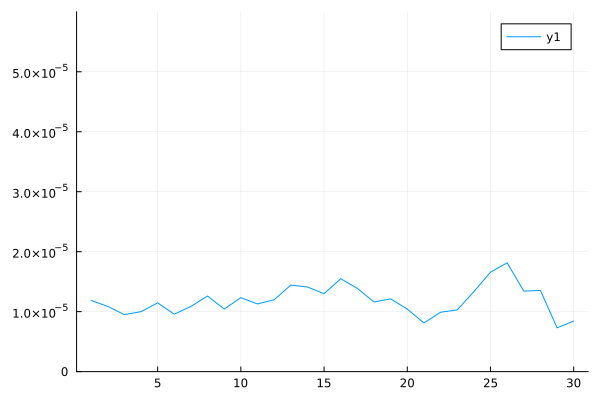

In [231]:
plot(sysfinal[end].vapor.δend,ylim=(0,6e-5))

In [ ]:
@gif for sysi in sysfinal[1:end]
    plot(sysi,plottype="P")
end

In [ ]:
@gif for sysi in sysfinal[end:end]
    plot(sysi,plottype="ΔT",ylim=(-1.0,1.0))
end

In [ ]:
@gif for sysi in sysfinal[end:end]
     plot(sysi,plottype="T",xlim=(1,1.5))
end

In [ ]:
Tmax = maximum(plate_T_hist[20])
Tmin = minimum(plate_T_hist[1])

@gif for i = 20:20
heatmap(plate_T_hist[i],sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clim=(Tmin,Tmax),line_z=0,xlabel="x [m]",ylabel="y [m]",title=string("time = ", round(tube_hist[i].t, digits=2), "[s] \n",  "T[K]"))
scatter!([x[1],x[4],x[8]],[y[1],y[4],y[8]])
annotate!(x[1]+0.002, y[1]+0.005, "RTD1", :color)
annotate!(x[4]+0.002, y[4]+0.005, "RTD4", :color)
annotate!(x[8]+0.002, y[8]+0.005, "RTD8", :color,legend=false)
end




In [ ]:
savefig("T_profile.svg")

In [ ]:
Tmax = maximum(plate_T_hist[end])
Tmin = minimum(plate_T_hist[1])

@gif for i = 1:1:length(plate_T_hist)
heatmap(plate_T_hist[i],sys.grid,legend=true,color=cgrad(:thermal),xlimit=xlim,ylimit=ylim,clim=(Tmin,Tmax),line_z=0,xlabel="x [m]",ylabel="y [m]",title=string("time = ", round(tube_hist_t[i], digits=2), "[s] \n",  "T[K]"))
scatter!([x[1],x[4],x[8]],[y[1],y[4],y[8]])
annotate!(x[1]+0.002, y[1]+0.005, "RTD1", :white)
annotate!(x[4]+0.002, y[4]+0.005, "RTD4", :white)
annotate!(x[8]+0.002, y[8]+0.005, "RTD8", :white,legend=false)
end



In [ ]:
sysfinal[end].tube.angle

## Store data

In [ ]:
using JLD2

In [ ]:
boil_station_hist = [elem[1] for elem in boil_hist]
boil_t_hist = [elem[2] for elem in boil_hist]
boil_data = Array(reshape([boil_station_hist;boil_t_hist], length(boil_t_hist),2));

In [ ]:
save(dirname(dirname(dirname(pwd())))*"/OHPnume/OHP2_20W_E030_1_DT1_large.jld2",
    "tube_hist_θwall", tube_hist_θwall,"tube_hist_u", tube_hist_u,"tube_hist_t", tube_hist_t,
    "integrator_tube",integrator_tube,"plate_T_hist", plate_T_hist,
    "integrator_plate", integrator_plate, "boil_data", boil_data,"ohp",ohp)

In [ ]:
boil_data

In [ ]:
scatter(boil_data[:,2],boil_data[:,1])

In [ ]:
sorted_boil_hist = boil_data[sortperm(boil_data[:, 1]), :]
num_boiling = zeros(size(Xstations))
for i = 1:size(sorted_boil_hist,1)
    num_boiling[Int64(sorted_boil_hist[i,1])] += 1
end

In [ ]:
using SparseArrays 

In [ ]:
boil_dt = 0.1

In [ ]:
tend = round(integrator_tube.t)

boil_matrix=spzeros(size(Xstations,1),Int64(round(tend/boil_dt)));
for tnum = 1:size(boil_matrix,2)
     boil_index = findall(x->Int64(round(x/boil_dt))==tnum,boil_data[:,2])
   
    if length(boil_index) != 0
        i_station_temp = Int64.(boil_data[boil_index,1])
        for i in i_station_temp
            boil_matrix[i,tnum] = 1
        end
    end
end



In [ ]:
boil_num_t = sum(boil_matrix, dims=1)'
boil_num_x = sum(boil_matrix, dims=2);

In [ ]:
plot(boil_num_t)

In [ ]:
using EasyFit

m10 = movavg(vec(boil_num_t),10)

In [ ]:
plot(m10.x)

In [ ]:
Lliquidslug = zeros(length(sysfinal))
for i = 1:length(sysfinal)
    Lliquidslug[i] = sum(XptoLliquidslug(sysfinal[i].liquid.Xp,sysfinal[i].tube.L))
end
plot(Lliquidslug)

In [ ]:
sysfinal[450].vapor.δstart

## T line graph comparision

In [ ]:
using XLSX

In [ ]:
filepath = "20190613_F_PD_%23008_O002_H001_P040_expA.xlsx"
# filepath = "20190612_F_PD_%23007_O002_H001_P030_expA.xlsx"
# filepath = "20190606_F_PD_%23006_O002_H001_P020_expA.xlsx"
xf = XLSX.readxlsx(dirname(dirname(dirname(pwd())))*"/OHPexp/"*filepath)

Onum, Hnum, power = getconfig(filepath)
RTD,RTDt = getRTD(xf,Onum);

In [ ]:
# inch = 2.54e-2;

x = [-2.75inch,-1.4inch,-0.8inch,0.0,0.0,0.8inch,1.4inch,2.75inch]
y = [0.0,0.0,0.0,0.0,0.4inch,0.0,0.0,0.0];
X =  VectorData(x,y);

In [ ]:
H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
g = ScalarData(X);

In [ ]:
ghist = getghist(g,H,plate_T_hist);
thist = tube_hist_t;

In [ ]:
wetness = getwetness(sysfinal);
Vabs_avg,Vavg,Vabs_max = getV(sysfinal);
δ_avg_start,δ_avg_end = getδ(sysfinal);

In [ ]:
using Statistics

In [ ]:
mean(δ_avg_start)

In [ ]:
sorted_boil_hist = boil_data[sortperm(boil_data[:, 1]), :]
num_boiling = zeros(size(Xstations))
for i = 1:size(sorted_boil_hist,1)
    num_boiling[Int64(sorted_boil_hist[i,1])] += 1
end

In [ ]:
using SparseArrays 

In [ ]:
boil_dt = 0.1

In [ ]:
tend = round(integrator_tube.t)

boil_matrix=spzeros(size(Xstations,1),Int64(round(tend/boil_dt)));
for tnum = 1:size(boil_matrix,2)
     boil_index = findall(x->Int64(round(x/boil_dt))==tnum,boil_data[:,2])
   
    if length(boil_index) != 0
        i_station_temp = Int64.(boil_data[boil_index,1])
        for i in i_station_temp
            boil_matrix[i,tnum] = 1
        end
    end
end



In [ ]:
boil_num_t = sum(boil_matrix, dims=1)'
boil_num_x = sum(boil_matrix, dims=2);

In [ ]:
i = 8 #RTD number

plot(thist,ghist[i] .-Tref,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,300.0))

i = 4 #RTD number

plot!(thist,ghist[i] .-Tref,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,300.0))

i = 1 #RTD number
plot!(thist,ghist[i] .-Tref,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i],legend=:topright, label=string("RTD", i," experiment"),xlim=(0.0,100.0),xlabel="time[s]",ylabel="T-T0[K]",ylim=(0,40))

In [ ]:
i1 = 4 #RTD number
i2 = 8 #RTD number

plot(thist, power ./ (ghist[i1] .-ghist[i2]),label=string("10 Watt heater simulation"),linewidth=2,ylim=(0,5))
scatter!(RTDt .- RTDt[1],power ./(RTD[:,i1] .- RTD[:,i2]), label=string("10 Watt heater experiment (Drolen et. al, 2021)"),legend=:topright,xlim=(0.0,100.0),title="thermal conductance ",xlabel="time [s]",ylabel="P/(T₄-T₈) [W/K]")

In [ ]:
power ./ (ghist[i1] .-ghist[i2])

In [ ]:
plot(power ./ (ghist[i1] .-ghist[i2]),ylim=(1,2))

In [ ]:
savefig("conductance40W.svg")

In [ ]:
scatter(sysfinal[end-2].vapor.δ)

In [ ]:
Xp_hist = zeros(length(sysfinal))
num = 2
for i = 1:length(sysfinal)
    for j = length(sysfinal[i].liquid.Xp)
#         Xp_hist[i] = sysfinal[i].liquid.Xp[end][end]
        Xp_hist[i] = sysfinal[i].liquid.Xp[1][1]
    end
end

# plot(thist,Xp_hist,label= "FFT of liquid slug interface 1",xlabel="FFT frequency [Hz]")
plot(thist,Xp_hist,label= "FFT of liquid slug interface N",xlabel="time [s]",ylabel="Xp [m]",legend=:topleft)

In [ ]:
dtt = 0.01
fs = 1/dtt

In [ ]:
LL = length(Xp_hist)
Y= fft(Xp_hist .- sum(Xp_hist)./LL )

P2 = abs.(Y/LL);
P1 = P2[1:Int64((LL-1)/2+1)];
P1[2:end-1] = 2*P1[2:end-1];
plot(LinRange(0.0,0.5fs,length(P1)),P1,xlim=(0,20),label= "FFT of liquid slug interface 1",xlabel="FFT frequency [Hz]")

In [ ]:
plot(Xp1_hist)

In [ ]:

velocity_avg = zeros(length(sysfinal))
velocity_max = zeros(length(sysfinal))

for i = 1:length(sysfinal)
    tmp = 0
    for j = length(sysfinal[i].liquid.dXdt)
        tmp += abs(sysfinal[i].liquid.dXdt[j][1])
    
        velocity_avg[i] = tmp/j
    end
    
    velocity_max[i] = maximum(abs.(sysfinal[i].liquid.dXdt[:][1]))
end



In [ ]:
plot(thist,velocity_avg,label="v avg")
plot!(thist,velocity_max,label="v max",xlabel="t [s]", ylabel="v [m/s]")

In [ ]:
d = tube_d
δmin = 5e-3*d

In [ ]:
δmin:1e-6:d/2

In [ ]:
Hfilm

## film H v.s. thickness

In [ ]:
sys0.vapor.δmin

In [ ]:
plot(0.0:1e-8:tube_d/8,Hfilm.(0.0:1e-8:tube_d/8,[sys0]),xlabel="δ[m]",ylabel="h [W/m²/K]")

### Total mass of the system

In [110]:


thist = []
    for i = 1:length(tube_hist)
        append!(thist,tube_hist[i].t)
    end

LoadError: UndefVarError: tube_hist not defined

In [111]:
# i = 100
Mass = zeros(length(sysfinal))
M1hist = zeros(length(sysfinal))
M2hist = zeros(length(sysfinal))
M3hist = zeros(length(sysfinal))
for i = 1:length(sysfinal)
    δarea = Ac .* (1 .- ((tube_d .- 2*sysfinal[i].vapor.δ ) ./ tube_d) .^ 2);
    Lvaporplug = XptoLvaporplug(sysfinal[i].liquid.Xp,sysfinal[i].tube.L,sysfinal[i].tube.closedornot)
    Lliquidslug = XptoLliquidslug(sysfinal[i].liquid.Xp,sysfinal[i].tube.L)
    δarea .* Lvaporplug .* ρₗ .+ PtoD.(sysfinal[i].vapor.P) .* (Ac .- δarea) .* Lvaporplug
    M1 = δarea .* Lvaporplug .* ρₗ
    M2 = PtoD.(sysfinal[i].vapor.P) .* (Ac .- δarea) .* Lvaporplug
    M3 = ρₗ .* Ac .* Lliquidslug
    
    Mass[i] = sum(M1+M2)+sum(M3)
    M1hist[i] = sum(M1)
    M2hist[i] = sum(M2)
    M3hist[i] = sum(M3)
#     Mass[i] = sum(M1)
end
# println(sum(M1+M2)+sum(M3))
# println(sum(M1+M2))
# println(sum(M3))
# plot(M3hist/Mass[1])
# subplot(Mass/Mass[1])

LoadError: type Vapor has no field δ

In [112]:
Mass/Mass[1]

3-element Vector{Float64}:
 NaN
 NaN
 NaN

In [ ]:
l = @layout [a b ; c d]
p1 = plot(thist,Mass/Mass[1],label = "relative total mass",legend=:bottomright,ylim=(0.99,1.01))
p2 = plot(thist,M1hist/Mass[1],label = "relative film mass",legend=:bottomright)
p3 = plot(thist,M2hist/Mass[1],label = "relative vapor mass",legend=:bottomright)
p4 = plot(thist,M3hist/Mass[1],label = "relative liquid mass")
plot(p1, p2, p3, p4, layout = l)

In [ ]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=palette([:blue, :gold], 100),line_z=Htmp,xlabel="x ",ylabel="y ",title=string("time = ", round(tube_hist[i].t, digits=2), "[s] \n",  "T - T0 [K]"),border=:none,axis=nothing)
end

In [ ]:
@gif for i=1:1:length(sysfinal)
V = [elem[2] for elem in sysfinal[i].liquid.dXdt]
histogram(V,bins=-2:0.1:2,ylim=(0,20),title="hahaha") 
end

In [ ]:
@gif for i=1:1:length(sysfinal)
δs = sysfinal[i].vapor.δ
histogram(δs,bins=3.5e-5:0.25e-6:4.5e-5,ylim=(0,20),title="hahaha") 
end

In [ ]:
sysfinal[end].vapor.δstart;

In [ ]:
x_map = 0:1e-3:L
Hwall = zeros(size(x_map)[1],length(sysfinal))
for i in eachindex(sysfinal)
    Hwall[:,i] = sysfinal[i].mapping.H_interp_liquidtowall[x_map]
end

function liquidorvapor(Hwall_one,liquidthres=1000,dryvaporthres=100)
    indicator = (Hwall_one > dryvaporthres && Hwall_one < liquidthres) ? 0 : 1
end

In [ ]:
indicator = liquidorvapor.(Hwall');

In [ ]:
dt_record

In [ ]:
dt_range = range(dt_record,dt_record,size(indicator,2))

In [ ]:
indicator

In [ ]:
# heatmap(x_map,thist,indicator,xlabel="ξ [m]", ylabel="t [s]",title="0->liquid, 1->vapor",xlim=(1,2),ylim=(6,10))

In [ ]:
heatmap(x_map,thist,indicator, color=palette([:black, :white], 2),xlabel="ξ [m]",ylabel="t [s]",title="OHP2 big heater 40W black->liquid, white->vapor" ,ylim=(10,20),colorbar=false,framestyle = :box)
# heatmap!(ohpξ,[thist[1];thist[end]],hc_indicator_matrix,color=palette([:blue, :red], 2),opacity=0.2)

In [ ]:
savefig("allliquidslugs.pdf")

In [ ]:
heatmap(ohpξ,[thist[1];thist[end]],hc_indicator_matrix,color=palette([:blue, :white, :red], 3),xlabel="ξ [m]",ylabel="t [s]",title="red->heater, white->adiabatic, blue->condenser",colorbar=false,framestyle = :box)

In [ ]:
savefig("heatercondenser.pdf")

In [ ]:
heatmap(x_map,thist,indicator,xlabel="ξ [m]", color=palette([:black, :white], 2),ylabel="t [s]",title="OHP2 big heater 40W, black->liquid, white->vapor",ylim=(0,10))
heatmap!(ohpξ,[thist[1];thist[end]],hc_indicator_matrix,color=palette([:blue, :white, :red], 3),opacity=0.2,framestyle = :box,colorbar=false)

In [ ]:
savefig("liquidvaporandheatercondenser.pdf")

In [ ]:
plot(ohp.x)

In [ ]:
(abs.(ohp.x) .> x_thres_bigheater[1]);

In [ ]:
ohpξ = 0:L/length(ohp.x):(L-L/length(ohp.x));
x_thres = 2.5inch - 0.5inch*0.9;
condenser_indicator = -(ohp.x .> x_thres);

x_thres_bigheater = (0.2inch,1.2inch)
heater_indicator = (abs.(ohp.x) .> x_thres_bigheater[1]) .* (abs.(ohp.x) .< x_thres_bigheater[2]);

hc_indicator = heater_indicator + condenser_indicator

In [ ]:
plot(ohpξ,hc_indicator)

In [ ]:
plot(ohpξ,condenser_indicator)

In [ ]:
hc_indicator_matrix = hcat(hc_indicator, hc_indicator)'

In [ ]:
[thist[1],thist[end]]

In [ ]:
size(ohpξ)

In [ ]:
[thist[1];thist[end]]

In [ ]:
heatmap(ohpξ,[thist[1];thist[end]],condenser_indicator_matrix,color=palette([:white, :blue], 2),opacity=0.1,colorbar=false)

In [ ]:
L = sysfinal[end].tube.L
chargeratio = []

for i =1:length(sysfinal)
    L_liquidslug = XptoLliquidslug(sysfinal[i].liquid.Xp,sysfinal[end].tube.L)
    push!(chargeratio,sum(L_liquidslug)/L)
end

chargeratio